In [11]:
'Empty seat or carrier seat Classification using XG Boost model and MLP model'

'Empty seat or carrier seat Classification using XG Boost model and MLP model'

In [ ]:
import gc
gc.collect()

1195

In [13]:
%reset -f

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

# Emptyseat measurements

In [15]:
import numpy as np
import pandas as pd
import os

# Path to the file (same as used when saving)
base_dir = "/Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code"
file_path = os.path.join(base_dir, "Data", "Processed", "Emptyseat_npy_array_Lowpassfiltered_label.npy")

# Load the NumPy array from the file
loaded_array = np.load(file_path, mmap_mode='r')

# Now 'loaded_array' contains the NumPy array data that was saved in the file
dataframe_emptyseat = pd.DataFrame(loaded_array,columns=['Frequency','FFT Magnitude','Phase','Object_Presence'])
dataframe_emptyseat

# CM_LOG: True


,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,107430.816082,8.624599e-17,0.0
1,77.689936,52904.997022,-3.123763e+00,0.0
2,155.379873,2206.810461,1.927586e+00,0.0
3,233.069809,659.161326,-2.806674e+00,0.0
4,310.759745,2349.137520,-1.099962e+00,0.0
...,...,...,...,...
25135,-388.449682,2069.648470,-1.726686e+00,0.0
25136,-310.759745,2349.137520,1.099962e+00,0.0
25137,-233.069809,659.161326,2.806674e+00,0.0
25138,-155.379873,2206.810461,-1.927586e+00,0.0


In [16]:
num_rows_empty = len(dataframe_emptyseat)
num_rows_empty

25140

In [17]:
fft_magnitudes_empty = dataframe_emptyseat["FFT Magnitude"].values  # Convert to NumPy array
fft_magnitudes_empty

array([107430.81608173,  52904.99702179,   2206.81046075, ...,
          659.16132569,   2206.81046075,  52904.99702179], shape=(25140,))

In [18]:
fft_frequencies_empty = dataframe_emptyseat["Frequency"].values  # Convert to NumPy array
fft_frequencies_empty

array([   0.        ,   77.68993636,  155.37987271, ..., -233.06980907,
       -155.37987271,  -77.68993636], shape=(25140,))

In [19]:
fft_phase_empty = dataframe_emptyseat["Phase"].values  # Convert to NumPy array
fft_phase_empty

array([ 8.62459917e-17, -3.12376323e+00,  1.92758581e+00, ...,
        2.80667375e+00, -1.92758581e+00,  3.12376323e+00], shape=(25140,))

In [20]:
import numpy as np
from scipy.stats import entropy
from scipy.signal import find_peaks

def extract_features(fft_freqs, fft_mags, fft_phase):
    # Normalize magnitudes to prevent division errors
    norm_mags = fft_mags / np.sum(fft_mags) if np.sum(fft_mags) > 0 else fft_mags
    
    # Spectral Centroid (Weighted Mean of Frequencies)
    spectral_centroid = np.sum(fft_freqs * norm_mags) / np.sum(norm_mags)

    # Spectral Bandwidth (Spread around centroid)
    spectral_bandwidth = np.sqrt(np.sum(norm_mags * (fft_freqs - spectral_centroid) ** 2))

    # Spectral Flatness (Geometric Mean / Arithmetic Mean)
    spectral_flatness = np.exp(np.mean(np.log(fft_mags + 1e-10))) / np.mean(fft_mags + 1e-10)

    # Phase Features
    phase_variance = np.var(fft_phase)  # Variance of phase angles
    phase_mean = np.mean(fft_phase)  # Mean of phase angles
    phase_diff = np.mean(np.diff(fft_phase))  # Average phase difference between frequencies

    return {
        "mean_fft": np.mean(fft_mags),
        "std_fft": np.std(fft_mags),
        "max_fft": np.max(fft_mags),
        "min_fft": np.min(fft_mags),
        "median_fft": np.median(fft_mags),
        "sum_fft": np.sum(fft_mags),
        "spectral_entropy": entropy(norm_mags),  # Energy spread
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        "phase_variance": phase_variance,
        "phase_mean": phase_mean,
        "phase_diff": phase_diff,
    }


In [21]:
# Function to apply perturbation based on reference values
def add_perturbation(reference_features, num_rows, perturb_range=0.03):
    perturbed_data = []
    
    for _ in range(num_rows):
        perturbed_features = {
            key: value * (1 + np.random.uniform(-perturb_range, perturb_range)) 
            for key, value in reference_features.items()
        }
        perturbed_data.append(perturbed_features)
    
    return pd.DataFrame(perturbed_data)

In [22]:
# Extract features for fft_empty
reference_features_empty = extract_features(fft_frequencies_empty, fft_magnitudes_empty, fft_phase_empty)
reference_features_empty
# CM_LOG: True


{'mean_fft': np.float64(802.0868511355409),
 'std_fft': np.float64(942.742113907109),
 'max_fft': np.float64(107430.81608172639),
 'min_fft': np.float64(3.728687324337578),
 'median_fft': np.float64(714.1010047319869),
 'sum_fft': np.float64(20164463.437547497),
 'spectral_entropy': np.float64(9.930180078426575),
 'spectral_centroid': np.float64(-11.678021676198114),
 'spectral_bandwidth': np.float64(576450.1635782213),
 'phase_variance': np.float64(3.2795763369345656),
 'phase_mean': np.float64(5.652686839778045e-17),
 'phase_diff': np.float64(0.000124259645445658)}

In [23]:
# Generate a DataFrame with perturbed values for all rows in fft_empty
num_rows_empty = len(dataframe_emptyseat)
perturbed_empty_df = add_perturbation(reference_features_empty, num_rows_empty, perturb_range=0.03)
perturbed_empty_df
# CM_LOG: True


,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,792.971876,956.970325,106969.541709,3.775421,697.870471,2.070878e+07,10.164156,-11.705897,561332.688576,3.350592,5.535068e-17,0.000124
1,784.519210,967.825816,104734.417834,3.737669,702.831795,1.978338e+07,10.006890,-11.830049,576941.818905,3.282264,5.718299e-17,0.000124
2,781.491206,915.824829,106662.688159,3.710415,709.407289,2.026734e+07,9.756229,-11.929340,587884.857571,3.231304,5.788022e-17,0.000128
3,794.037011,946.701606,109895.538684,3.688466,699.389593,2.009317e+07,9.893417,-11.386820,561597.413105,3.283984,5.498098e-17,0.000127
4,782.498517,948.959616,105740.019822,3.630659,693.903542,2.067128e+07,10.143147,-11.807360,561042.840045,3.181829,5.697582e-17,0.000124
...,...,...,...,...,...,...,...,...,...,...,...,...
25135,779.934498,969.320972,105232.493274,3.649033,700.449414,2.015641e+07,10.076429,-11.430103,574795.897883,3.377390,5.704464e-17,0.000125
25136,807.849908,917.603455,105577.151688,3.649978,699.826706,2.069567e+07,9.686899,-11.605918,566122.388926,3.224098,5.688756e-17,0.000122
25137,802.998679,960.680135,107652.960183,3.732581,711.157934,2.029908e+07,9.790037,-11.327834,572024.557888,3.292723,5.499986e-17,0.000124
25138,816.917932,947.289405,109504.187812,3.780307,707.978787,2.037966e+07,10.194852,-11.583675,582871.659805,3.197022,5.604699e-17,0.000121


In [24]:
dataframe_emptyseat

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,107430.816082,8.624599e-17,0.0
1,77.689936,52904.997022,-3.123763e+00,0.0
2,155.379873,2206.810461,1.927586e+00,0.0
3,233.069809,659.161326,-2.806674e+00,0.0
4,310.759745,2349.137520,-1.099962e+00,0.0
...,...,...,...,...
25135,-388.449682,2069.648470,-1.726686e+00,0.0
25136,-310.759745,2349.137520,1.099962e+00,0.0
25137,-233.069809,659.161326,2.806674e+00,0.0
25138,-155.379873,2206.810461,-1.927586e+00,0.0


In [25]:
len(perturbed_empty_df),len(dataframe_emptyseat)

(25140, 25140)

In [26]:
# Ensure both DataFrames have the same number of rows
if len(dataframe_emptyseat) != len(perturbed_empty_df):
    print("The DataFrames have different lengths. Adjust them to have the same number of rows before concatenating.")
else:
    # Concatenate the DataFrames side by side
    dataframe_emptyseat_withfeatures = pd.concat([dataframe_emptyseat, perturbed_empty_df], axis=1)

# Display the first few rows of the updated dataframe_emptyseat to verify
dataframe_emptyseat_withfeatures.head()

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,107430.816082,8.624599e-17,0.0,792.971876,956.970325,106969.541709,3.775421,697.870471,2.070878e+07,10.164156,-11.705897,561332.688576,3.350592,5.535068e-17,0.000124
1,77.689936,52904.997022,-3.123763e+00,0.0,784.519210,967.825816,104734.417834,3.737669,702.831795,1.978338e+07,10.006890,-11.830049,576941.818905,3.282264,5.718299e-17,0.000124
2,155.379873,2206.810461,1.927586e+00,0.0,781.491206,915.824829,106662.688159,3.710415,709.407289,2.026734e+07,9.756229,-11.929340,587884.857571,3.231304,5.788022e-17,0.000128
3,233.069809,659.161326,-2.806674e+00,0.0,794.037011,946.701606,109895.538684,3.688466,699.389593,2.009317e+07,9.893417,-11.386820,561597.413105,3.283984,5.498098e-17,0.000127
4,310.759745,2349.137520,-1.099962e+00,0.0,782.498517,948.959616,105740.019822,3.630659,693.903542,2.067128e+07,10.143147,-11.807360,561042.840045,3.181829,5.697582e-17,0.000124


In [27]:
len(dataframe_emptyseat)

25140

# carrierseat measurements

In [ ]:
import os
import numpy as np
import pandas as pd
# Replace 'your_array_file.npy' with the actual file path of your saved NumPy array
# file_path = 'Carrierseat_withoutbaby_npy_array_Lowpassfiltered_withlabel_1.npy'

# Path to the file (same as used when saving)
base_dir = "/Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code"
file_path = os.path.join(base_dir, "Data", "Processed", "CarrierSeat_Lowpassfiltered_Label_1_Object_Presence.npy")

# Load the NumPy array from the file
loaded_array = np.load(file_path, mmap_mode='r')

# Now 'loaded_array' contains the NumPy array data that was saved in the file
dataframe_carrierseat = pd.DataFrame(loaded_array,columns=['Frequency','FFT Magnitude','Phase','Object_Presence'])
dataframe_carrierseat
# CM_LOG: True


,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,85482.192762,2.659895e-18,1.0
1,92.917460,40258.220857,-3.125651e+00,1.0
2,185.834919,5221.175683,2.865319e+00,1.0
3,278.752379,3160.342162,-3.600372e-01,1.0
4,371.669838,110.182115,-4.779431e-01,1.0
...,...,...,...,...
21015,-464.587298,862.049715,2.715918e+00,1.0
21016,-371.669838,110.182115,4.779431e-01,1.0
21017,-278.752379,3160.342162,3.600372e-01,1.0
21018,-185.834919,5221.175683,-2.865319e+00,1.0


In [29]:
num_rows_carrier = len(dataframe_carrierseat)
num_rows_carrier

21020

In [30]:
fft_magnitudes_carrier = dataframe_carrierseat["FFT Magnitude"].values  # Convert to NumPy array
fft_magnitudes_carrier

array([85482.19276229, 40258.2208573 ,  5221.17568315, ...,
        3160.34216223,  5221.17568315, 40258.2208573 ], shape=(21020,))

In [31]:
fft_frequencies_carrier = dataframe_carrierseat["Frequency"].values  # Convert to NumPy array
fft_frequencies_carrier

array([   0.        ,   92.91745956,  185.83491912, ..., -278.75237869,
       -185.83491912,  -92.91745956], shape=(21020,))

In [32]:
fft_phase_carrier = dataframe_carrierseat["Phase"].values  # Convert to NumPy array
fft_phase_carrier

array([ 2.65989521e-18, -3.12565096e+00,  2.86531883e+00, ...,
        3.60037221e-01, -2.86531883e+00,  3.12565096e+00], shape=(21020,))

In [ ]:
# Extract features for fft_carrier
reference_features_carrier = extract_features(fft_frequencies_carrier, fft_magnitudes_carrier, fft_phase_carrier)
reference_features_carrier
# CM_LOG: True



{'mean_fft': np.float64(1324.5490253896191),
 'std_fft': np.float64(1163.1363362657507),
 'max_fft': np.float64(85482.19276229314),
 'min_fft': np.float64(5.39114437034456),
 'median_fft': np.float64(1093.2807341922792),
 'sum_fft': np.float64(27842020.513689794),
 'spectral_entropy': np.float64(9.714927149619292),
 'spectral_centroid': np.float64(-29.998974694812205),
 'spectral_bandwidth': np.float64(605607.1902130501),
 'phase_variance': np.float64(3.3064155598843628),
 'phase_mean': np.float64(0.00014945730987581745),
 'phase_diff': np.float64(0.00014870597824614428)}

In [34]:
# Generate a DataFrame with perturbed values for all rows in fft_empty
num_rows_carrier = len(dataframe_carrierseat)
perturbed_carrier_df = add_perturbation(reference_features_carrier, num_rows_carrier, perturb_range=0.03)
perturbed_carrier_df

,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,1359.154954,1178.466208,83675.707491,5.481478,1088.366172,2.754164e+07,9.955427,-29.967024,589089.611011,3.305657,0.000148,0.000146
1,1315.908698,1159.137402,85140.660226,5.394959,1079.615240,2.752399e+07,9.466269,-30.533082,602967.947511,3.395111,0.000152,0.000148
2,1361.135652,1132.528634,86022.694036,5.480376,1069.601489,2.703732e+07,9.678375,-29.278645,619922.759645,3.383225,0.000150,0.000150
3,1355.511457,1190.003034,83468.078965,5.413004,1103.457160,2.863695e+07,9.488149,-29.139499,593108.902385,3.395588,0.000153,0.000152
4,1284.940319,1174.917603,85874.096108,5.437409,1070.412046,2.842649e+07,9.674896,-30.431063,601151.480964,3.267175,0.000151,0.000153
...,...,...,...,...,...,...,...,...,...,...,...,...
21015,1346.113893,1142.852976,83492.864643,5.317069,1064.919424,2.794948e+07,9.498202,-30.217629,608131.793192,3.359054,0.000152,0.000147
21016,1363.983559,1132.607864,85981.560623,5.396071,1119.131398,2.798845e+07,9.638930,-30.718093,607410.703238,3.211312,0.000150,0.000150
21017,1362.069830,1190.899542,85838.949113,5.395711,1122.671431,2.867084e+07,9.680019,-30.598384,611174.159846,3.359500,0.000150,0.000148
21018,1334.383599,1129.180011,83559.954380,5.360356,1104.185742,2.727918e+07,9.758807,-29.981431,595934.805746,3.334189,0.000150,0.000151


In [35]:
dataframe_carrierseat

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,85482.192762,2.659895e-18,1.0
1,92.917460,40258.220857,-3.125651e+00,1.0
2,185.834919,5221.175683,2.865319e+00,1.0
3,278.752379,3160.342162,-3.600372e-01,1.0
4,371.669838,110.182115,-4.779431e-01,1.0
...,...,...,...,...
21015,-464.587298,862.049715,2.715918e+00,1.0
21016,-371.669838,110.182115,4.779431e-01,1.0
21017,-278.752379,3160.342162,3.600372e-01,1.0
21018,-185.834919,5221.175683,-2.865319e+00,1.0


In [36]:
len(perturbed_carrier_df),len(dataframe_carrierseat)

(21020, 21020)

In [37]:

# Ensure both DataFrames have the same number of rows
if len(dataframe_carrierseat) != len(perturbed_carrier_df):
    print("The DataFrames have different lengths. Adjust them to have the same number of rows before concatenating.")
else:
    # Concatenate the DataFrames side by side
    dataframe_carrierseat_withfeatures = pd.concat([dataframe_carrierseat, perturbed_carrier_df], axis=1)

# Display the first few rows of the updated dataframe_emptyseat to verify
dataframe_carrierseat_withfeatures.head()

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,85482.192762,2.659895e-18,1.0,1359.154954,1178.466208,83675.707491,5.481478,1088.366172,2.754164e+07,9.955427,-29.967024,589089.611011,3.305657,0.000148,0.000146
1,92.917460,40258.220857,-3.125651e+00,1.0,1315.908698,1159.137402,85140.660226,5.394959,1079.615240,2.752399e+07,9.466269,-30.533082,602967.947511,3.395111,0.000152,0.000148
2,185.834919,5221.175683,2.865319e+00,1.0,1361.135652,1132.528634,86022.694036,5.480376,1069.601489,2.703732e+07,9.678375,-29.278645,619922.759645,3.383225,0.000150,0.000150
3,278.752379,3160.342162,-3.600372e-01,1.0,1355.511457,1190.003034,83468.078965,5.413004,1103.457160,2.863695e+07,9.488149,-29.139499,593108.902385,3.395588,0.000153,0.000152
4,371.669838,110.182115,-4.779431e-01,1.0,1284.940319,1174.917603,85874.096108,5.437409,1070.412046,2.842649e+07,9.674896,-30.431063,601151.480964,3.267175,0.000151,0.000153


In [38]:
dataframe_emptyseat

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,107430.816082,8.624599e-17,0.0
1,77.689936,52904.997022,-3.123763e+00,0.0
2,155.379873,2206.810461,1.927586e+00,0.0
3,233.069809,659.161326,-2.806674e+00,0.0
4,310.759745,2349.137520,-1.099962e+00,0.0
...,...,...,...,...
25135,-388.449682,2069.648470,-1.726686e+00,0.0
25136,-310.759745,2349.137520,1.099962e+00,0.0
25137,-233.069809,659.161326,2.806674e+00,0.0
25138,-155.379873,2206.810461,-1.927586e+00,0.0


In [39]:
dataframe_carrierseat

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,85482.192762,2.659895e-18,1.0
1,92.917460,40258.220857,-3.125651e+00,1.0
2,185.834919,5221.175683,2.865319e+00,1.0
3,278.752379,3160.342162,-3.600372e-01,1.0
4,371.669838,110.182115,-4.779431e-01,1.0
...,...,...,...,...
21015,-464.587298,862.049715,2.715918e+00,1.0
21016,-371.669838,110.182115,4.779431e-01,1.0
21017,-278.752379,3160.342162,3.600372e-01,1.0
21018,-185.834919,5221.175683,-2.865319e+00,1.0


In [ ]:
# Vertical concatenation
dataset_1_rawdata = pd.concat([dataframe_emptyseat,dataframe_carrierseat])
dataset_1_rawdata
# CM_LOG: True



,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,107430.816082,8.624599e-17,0.0
1,77.689936,52904.997022,-3.123763e+00,0.0
2,155.379873,2206.810461,1.927586e+00,0.0
3,233.069809,659.161326,-2.806674e+00,0.0
4,310.759745,2349.137520,-1.099962e+00,0.0
...,...,...,...,...
21015,-464.587298,862.049715,2.715918e+00,1.0
21016,-371.669838,110.182115,4.779431e-01,1.0
21017,-278.752379,3160.342162,3.600372e-01,1.0
21018,-185.834919,5221.175683,-2.865319e+00,1.0


In [41]:
# Resetting the index if unique indices are needed
dataset_1_rawdata = dataset_1_rawdata.reset_index(drop=True)
dataset_1_rawdata

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,107430.816082,8.624599e-17,0.0
1,77.689936,52904.997022,-3.123763e+00,0.0
2,155.379873,2206.810461,1.927586e+00,0.0
3,233.069809,659.161326,-2.806674e+00,0.0
4,310.759745,2349.137520,-1.099962e+00,0.0
...,...,...,...,...
46155,-464.587298,862.049715,2.715918e+00,1.0
46156,-371.669838,110.182115,4.779431e-01,1.0
46157,-278.752379,3160.342162,3.600372e-01,1.0
46158,-185.834919,5221.175683,-2.865319e+00,1.0


In [42]:
dataframe_emptyseat_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,107430.816082,8.624599e-17,0.0,792.971876,956.970325,106969.541709,3.775421,697.870471,2.070878e+07,10.164156,-11.705897,561332.688576,3.350592,5.535068e-17,0.000124
1,77.689936,52904.997022,-3.123763e+00,0.0,784.519210,967.825816,104734.417834,3.737669,702.831795,1.978338e+07,10.006890,-11.830049,576941.818905,3.282264,5.718299e-17,0.000124
2,155.379873,2206.810461,1.927586e+00,0.0,781.491206,915.824829,106662.688159,3.710415,709.407289,2.026734e+07,9.756229,-11.929340,587884.857571,3.231304,5.788022e-17,0.000128
3,233.069809,659.161326,-2.806674e+00,0.0,794.037011,946.701606,109895.538684,3.688466,699.389593,2.009317e+07,9.893417,-11.386820,561597.413105,3.283984,5.498098e-17,0.000127
4,310.759745,2349.137520,-1.099962e+00,0.0,782.498517,948.959616,105740.019822,3.630659,693.903542,2.067128e+07,10.143147,-11.807360,561042.840045,3.181829,5.697582e-17,0.000124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25135,-388.449682,2069.648470,-1.726686e+00,0.0,779.934498,969.320972,105232.493274,3.649033,700.449414,2.015641e+07,10.076429,-11.430103,574795.897883,3.377390,5.704464e-17,0.000125
25136,-310.759745,2349.137520,1.099962e+00,0.0,807.849908,917.603455,105577.151688,3.649978,699.826706,2.069567e+07,9.686899,-11.605918,566122.388926,3.224098,5.688756e-17,0.000122
25137,-233.069809,659.161326,2.806674e+00,0.0,802.998679,960.680135,107652.960183,3.732581,711.157934,2.029908e+07,9.790037,-11.327834,572024.557888,3.292723,5.499986e-17,0.000124
25138,-155.379873,2206.810461,-1.927586e+00,0.0,816.917932,947.289405,109504.187812,3.780307,707.978787,2.037966e+07,10.194852,-11.583675,582871.659805,3.197022,5.604699e-17,0.000121


In [43]:
dataframe_carrierseat_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,85482.192762,2.659895e-18,1.0,1359.154954,1178.466208,83675.707491,5.481478,1088.366172,2.754164e+07,9.955427,-29.967024,589089.611011,3.305657,0.000148,0.000146
1,92.917460,40258.220857,-3.125651e+00,1.0,1315.908698,1159.137402,85140.660226,5.394959,1079.615240,2.752399e+07,9.466269,-30.533082,602967.947511,3.395111,0.000152,0.000148
2,185.834919,5221.175683,2.865319e+00,1.0,1361.135652,1132.528634,86022.694036,5.480376,1069.601489,2.703732e+07,9.678375,-29.278645,619922.759645,3.383225,0.000150,0.000150
3,278.752379,3160.342162,-3.600372e-01,1.0,1355.511457,1190.003034,83468.078965,5.413004,1103.457160,2.863695e+07,9.488149,-29.139499,593108.902385,3.395588,0.000153,0.000152
4,371.669838,110.182115,-4.779431e-01,1.0,1284.940319,1174.917603,85874.096108,5.437409,1070.412046,2.842649e+07,9.674896,-30.431063,601151.480964,3.267175,0.000151,0.000153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21015,-464.587298,862.049715,2.715918e+00,1.0,1346.113893,1142.852976,83492.864643,5.317069,1064.919424,2.794948e+07,9.498202,-30.217629,608131.793192,3.359054,0.000152,0.000147
21016,-371.669838,110.182115,4.779431e-01,1.0,1363.983559,1132.607864,85981.560623,5.396071,1119.131398,2.798845e+07,9.638930,-30.718093,607410.703238,3.211312,0.000150,0.000150
21017,-278.752379,3160.342162,3.600372e-01,1.0,1362.069830,1190.899542,85838.949113,5.395711,1122.671431,2.867084e+07,9.680019,-30.598384,611174.159846,3.359500,0.000150,0.000148
21018,-185.834919,5221.175683,-2.865319e+00,1.0,1334.383599,1129.180011,83559.954380,5.360356,1104.185742,2.727918e+07,9.758807,-29.981431,595934.805746,3.334189,0.000150,0.000151


In [44]:
# Vertical concatenation
dataset_1_withfeatures = pd.concat([dataframe_emptyseat_withfeatures,dataframe_carrierseat_withfeatures])
dataset_1_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,107430.816082,8.624599e-17,0.0,792.971876,956.970325,106969.541709,3.775421,697.870471,2.070878e+07,10.164156,-11.705897,561332.688576,3.350592,5.535068e-17,0.000124
1,77.689936,52904.997022,-3.123763e+00,0.0,784.519210,967.825816,104734.417834,3.737669,702.831795,1.978338e+07,10.006890,-11.830049,576941.818905,3.282264,5.718299e-17,0.000124
2,155.379873,2206.810461,1.927586e+00,0.0,781.491206,915.824829,106662.688159,3.710415,709.407289,2.026734e+07,9.756229,-11.929340,587884.857571,3.231304,5.788022e-17,0.000128
3,233.069809,659.161326,-2.806674e+00,0.0,794.037011,946.701606,109895.538684,3.688466,699.389593,2.009317e+07,9.893417,-11.386820,561597.413105,3.283984,5.498098e-17,0.000127
4,310.759745,2349.137520,-1.099962e+00,0.0,782.498517,948.959616,105740.019822,3.630659,693.903542,2.067128e+07,10.143147,-11.807360,561042.840045,3.181829,5.697582e-17,0.000124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21015,-464.587298,862.049715,2.715918e+00,1.0,1346.113893,1142.852976,83492.864643,5.317069,1064.919424,2.794948e+07,9.498202,-30.217629,608131.793192,3.359054,1.518490e-04,0.000147
21016,-371.669838,110.182115,4.779431e-01,1.0,1363.983559,1132.607864,85981.560623,5.396071,1119.131398,2.798845e+07,9.638930,-30.718093,607410.703238,3.211312,1.504043e-04,0.000150
21017,-278.752379,3160.342162,3.600372e-01,1.0,1362.069830,1190.899542,85838.949113,5.395711,1122.671431,2.867084e+07,9.680019,-30.598384,611174.159846,3.359500,1.500410e-04,0.000148
21018,-185.834919,5221.175683,-2.865319e+00,1.0,1334.383599,1129.180011,83559.954380,5.360356,1104.185742,2.727918e+07,9.758807,-29.981431,595934.805746,3.334189,1.503131e-04,0.000151


In [45]:
# Resetting the index if unique indices are needed
dataset_1_withfeatures = dataset_1_withfeatures.reset_index(drop=True)
dataset_1_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,107430.816082,8.624599e-17,0.0,792.971876,956.970325,106969.541709,3.775421,697.870471,2.070878e+07,10.164156,-11.705897,561332.688576,3.350592,5.535068e-17,0.000124
1,77.689936,52904.997022,-3.123763e+00,0.0,784.519210,967.825816,104734.417834,3.737669,702.831795,1.978338e+07,10.006890,-11.830049,576941.818905,3.282264,5.718299e-17,0.000124
2,155.379873,2206.810461,1.927586e+00,0.0,781.491206,915.824829,106662.688159,3.710415,709.407289,2.026734e+07,9.756229,-11.929340,587884.857571,3.231304,5.788022e-17,0.000128
3,233.069809,659.161326,-2.806674e+00,0.0,794.037011,946.701606,109895.538684,3.688466,699.389593,2.009317e+07,9.893417,-11.386820,561597.413105,3.283984,5.498098e-17,0.000127
4,310.759745,2349.137520,-1.099962e+00,0.0,782.498517,948.959616,105740.019822,3.630659,693.903542,2.067128e+07,10.143147,-11.807360,561042.840045,3.181829,5.697582e-17,0.000124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46155,-464.587298,862.049715,2.715918e+00,1.0,1346.113893,1142.852976,83492.864643,5.317069,1064.919424,2.794948e+07,9.498202,-30.217629,608131.793192,3.359054,1.518490e-04,0.000147
46156,-371.669838,110.182115,4.779431e-01,1.0,1363.983559,1132.607864,85981.560623,5.396071,1119.131398,2.798845e+07,9.638930,-30.718093,607410.703238,3.211312,1.504043e-04,0.000150
46157,-278.752379,3160.342162,3.600372e-01,1.0,1362.069830,1190.899542,85838.949113,5.395711,1122.671431,2.867084e+07,9.680019,-30.598384,611174.159846,3.359500,1.500410e-04,0.000148
46158,-185.834919,5221.175683,-2.865319e+00,1.0,1334.383599,1129.180011,83559.954380,5.360356,1104.185742,2.727918e+07,9.758807,-29.981431,595934.805746,3.334189,1.503131e-04,0.000151


# Training with rawdata

In [46]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load your dataset (df_combined)
X = dataset_1_rawdata.drop(columns=['Object_Presence'])  # Features
y = dataset_1_rawdata['Object_Presence']  # Labels

# Split into training & testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (XGBoost handles unscaled data well, but scaling can help)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data into DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up XGBoost parameters
params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',        # Loss function
    'max_depth': 6,                   # Depth of trees
    'learning_rate': 0.1,              # Step size shrinkage
    'n_estimators': 1000,               # Number of trees
    'random_state': 42
}

# Train XGBoost model
clf = xgb.XGBClassifier(**params)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report for rawdata:\n", classification_report(y_test, y_pred))
# CM_LOG: True


Accuracy: 0.6518630849220104

Classification Report for rawdata:
               precision    recall  f1-score   support

         0.0       0.65      0.77      0.71      5020
         1.0       0.65      0.51      0.57      4212

    accuracy                           0.65      9232
   macro avg       0.65      0.64      0.64      9232
weighted avg       0.65      0.65      0.65      9232



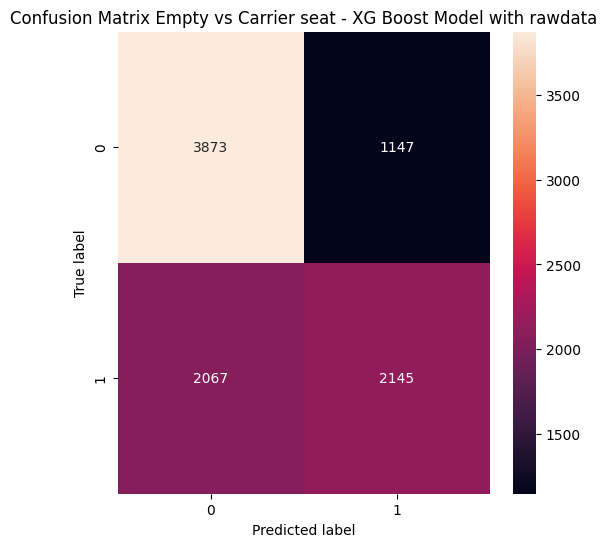

In [ ]:
# Generate confusion matrix
import io
import base64
from IPython.display import Image, display
cm = confusion_matrix(y_test, y_pred)
cm

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)  # Use fmt='d' for integer annotation
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix Empty vs Carrier seat - XG Boost Model with rawdata')
plt.show()
# CM_LOG: True

# Save figure to buffer and display as image
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches="tight")
buf.seek(0)
display(Image(data=buf.getvalue()))  # <---- This makes nbformat save the PNG, not text
plt.close(fig)



# Training with extracted features

In [49]:
# XG Boost Model with extracted features data

In [50]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load your dataset (df_combined)
X = dataset_1_withfeatures.drop(columns=['Object_Presence'])  # Features
y = dataset_1_withfeatures['Object_Presence']  # Labels

# Split into training & testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (XGBoost handles unscaled data well, but scaling can help)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data into DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up XGBoost parameters
params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',        # Loss function
    'max_depth': 6,                   # Depth of trees
    'learning_rate': 0.1,              # Step size shrinkage
    'n_estimators': 1000,               # Number of trees
    'random_state': 42
}

# Train XGBoost model
clf = xgb.XGBClassifier(**params)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report for extracted features data:\n", classification_report(y_test, y_pred))
# CM_LOG: True


Accuracy: 1.0

Classification Report for extracted features data:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5020
         1.0       1.00      1.00      1.00      4212

    accuracy                           1.00      9232
   macro avg       1.00      1.00      1.00      9232
weighted avg       1.00      1.00      1.00      9232



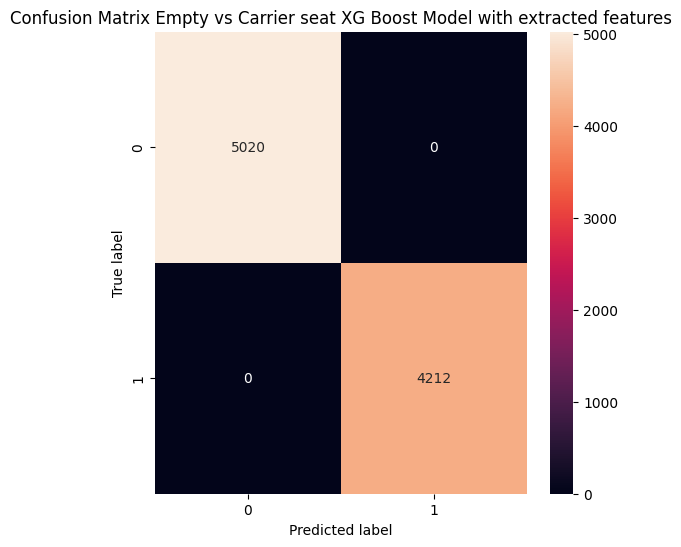

In [ ]:
# Generate confusion matrix
import io
import base64
from IPython.display import Image, display

cm = confusion_matrix(y_test, y_pred)
cm

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)  # Use fmt='d' for integer annotation
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix Empty vs Carrier seat XG Boost Model with extracted features')
plt.show()
# CM_LOG: True

# Save figure to buffer and display as image
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches="tight")
buf.seek(0)
display(Image(data=buf.getvalue()))  # <---- This makes nbformat save the PNG, not text
plt.close(fig)



/var/folders/0t/2wzx3xtd1ns5x1v0k6gxp2yc0000gn/T/ipykernel_37014/3590804500.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")


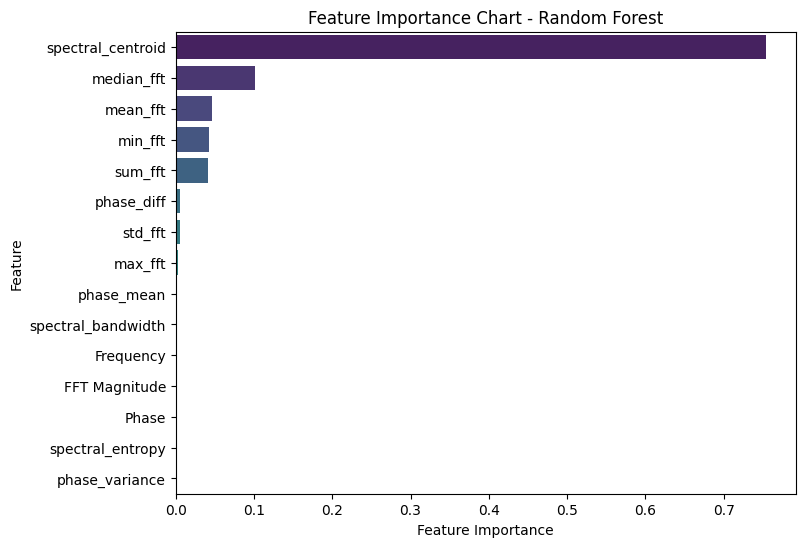

In [ ]:

# Feature Importance Plot
importances = clf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Chart - Random Forest")
plt.show()
# CM_LOG: True



# Feature selection for overcoming OVERFITTING

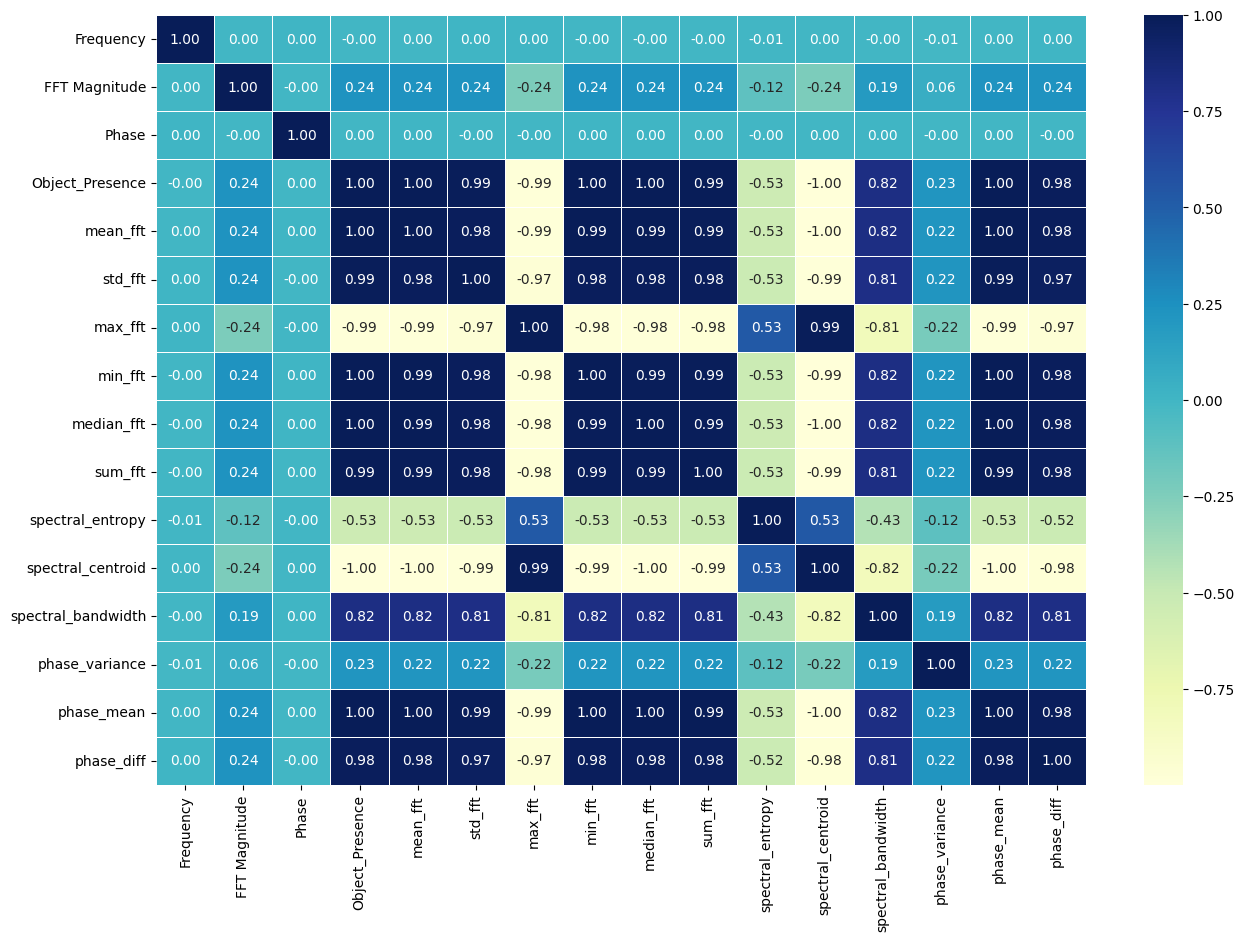

In [ ]:
# CM_LOG: True

# Plotting correlation matrix for extracted features
corr_matrix = dataset_1_withfeatures.corr()
fig= plt.subplots(figsize=(15, 10))
ax= sns.heatmap(corr_matrix,
               annot=True,
               linewidths=0.5,
               fmt='.2f',
               cmap='YlGnBu')



In [55]:
# Set a threshold for correlation (e.g., 0.8)
threshold = 0.8

# Find pairs of highly correlated features
highly_correlated = np.where(np.abs(corr_matrix) > threshold)

# Create a set to store the columns to drop
to_drop = set()

# Loop through the indices of the highly correlated pairs
for i, j in zip(*highly_correlated):
    if i != j:  # Avoid diagonal (self-correlation)
        feature_i = corr_matrix.columns[i]
        feature_j = corr_matrix.columns[j]
        # Ensure we do NOT drop 'Object_Presence'
        if feature_j != "Object_Presence":
            to_drop.add(feature_j)  # Drop one of the correlated features

# Drop the highly correlated features from the dataframe
dataset_1_reduced = dataset_1_withfeatures.drop(columns=to_drop)

# Display the dropped features and new dataframe shape
print("Dropped features: ", to_drop)
print("New dataframe shape: ", dataset_1_reduced.shape)


Dropped features:  {'std_fft', 'phase_diff', 'spectral_centroid', 'spectral_bandwidth', 'sum_fft', 'mean_fft', 'median_fft', 'max_fft', 'min_fft', 'phase_mean'}
New dataframe shape:  (46160, 6)


In [56]:
dataset_1_reduced

,Frequency,FFT Magnitude,Phase,Object_Presence,spectral_entropy,phase_variance
0,0.000000,107430.816082,8.624599e-17,0.0,10.164156,3.350592
1,77.689936,52904.997022,-3.123763e+00,0.0,10.006890,3.282264
2,155.379873,2206.810461,1.927586e+00,0.0,9.756229,3.231304
3,233.069809,659.161326,-2.806674e+00,0.0,9.893417,3.283984
4,310.759745,2349.137520,-1.099962e+00,0.0,10.143147,3.181829
...,...,...,...,...,...,...
46155,-464.587298,862.049715,2.715918e+00,1.0,9.498202,3.359054
46156,-371.669838,110.182115,4.779431e-01,1.0,9.638930,3.211312
46157,-278.752379,3160.342162,3.600372e-01,1.0,9.680019,3.359500
46158,-185.834919,5221.175683,-2.865319e+00,1.0,9.758807,3.334189


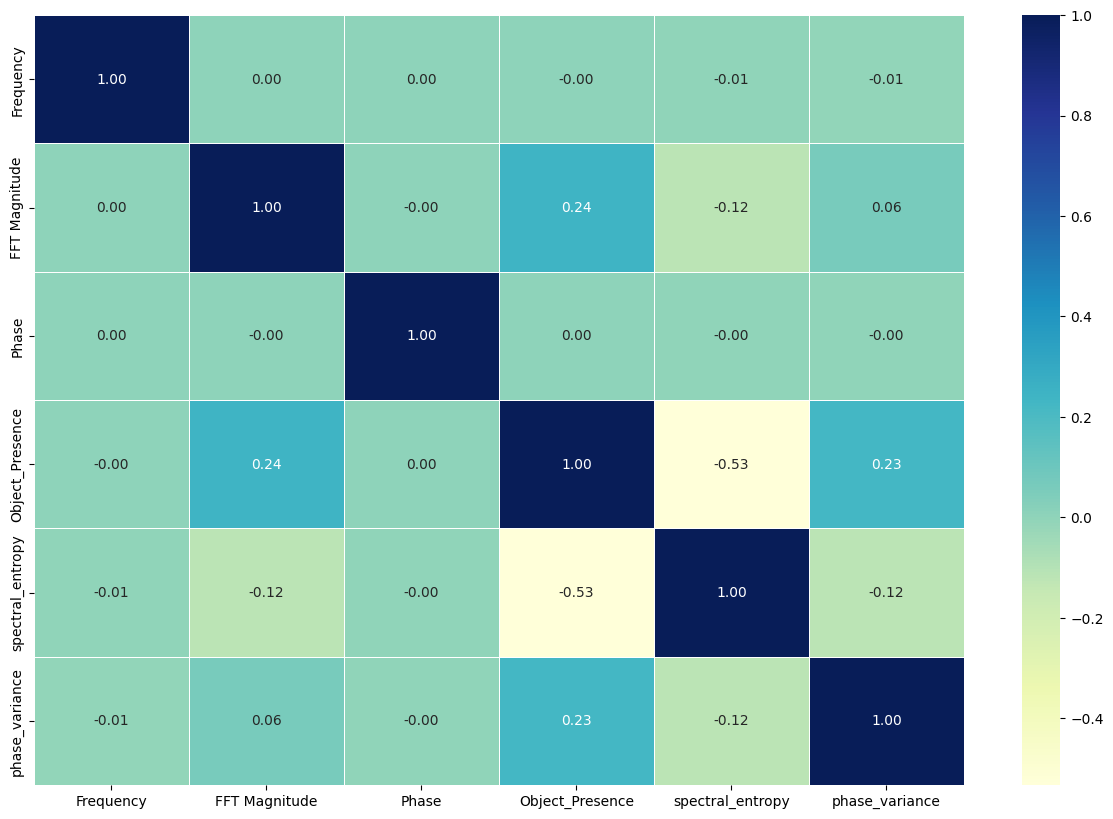

In [ ]:

# CM_LOG: True

corr_matrix = dataset_1_reduced.corr()
fig= plt.subplots(figsize=(15, 10))
ax= sns.heatmap(corr_matrix,
               annot=True,
               linewidths=0.5,
               fmt='.2f',
               cmap='YlGnBu')


# XG BOOST with selected features using Correlation matrix

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#dataset_1_reduced = dataset_1_reduced.drop(columns=['std_fft'])

# Load your dataset (df_combined)
X = dataset_1_reduced.drop(columns=['Object_Presence'])  # Features
y = dataset_1_reduced['Object_Presence']  # Labels




# Split into training & testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (XGBoost handles unscaled data well, but scaling can help)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data into DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up XGBoost parameters
params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',        # Loss function
    'max_depth': 6,                   # Depth of trees
    'learning_rate': 0.1,              # Step size shrinkage
    'n_estimators': 1000,               # Number of trees
    'random_state': 42
}

# Train XGBoost model
clf = xgb.XGBClassifier(**params)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report for selected features data:\n", classification_report(y_test, y_pred))
# CM_LOG: True



Accuracy: 0.8019930675909879

Classification Report for selected features data:
               precision    recall  f1-score   support

         0.0       0.79      0.86      0.83      5020
         1.0       0.81      0.73      0.77      4212

    accuracy                           0.80      9232
   macro avg       0.80      0.80      0.80      9232
weighted avg       0.80      0.80      0.80      9232



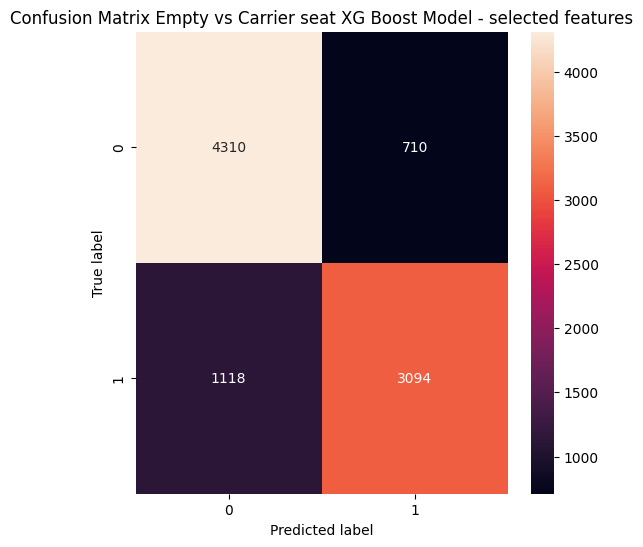

In [ ]:
# CM_LOG: True
import io
import base64
from IPython.display import Image, display# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)  # Use fmt='d' for integer annotation
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix Empty vs Carrier seat XG Boost Model - selected features')
plt.show()

# Save figure to buffer and display as image
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches="tight")
buf.seek(0)
display(Image(data=buf.getvalue()))  # <---- This makes nbformat save the PNG, not text
plt.close(fig)

/var/folders/0t/2wzx3xtd1ns5x1v0k6gxp2yc0000gn/T/ipykernel_37014/3590804500.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")


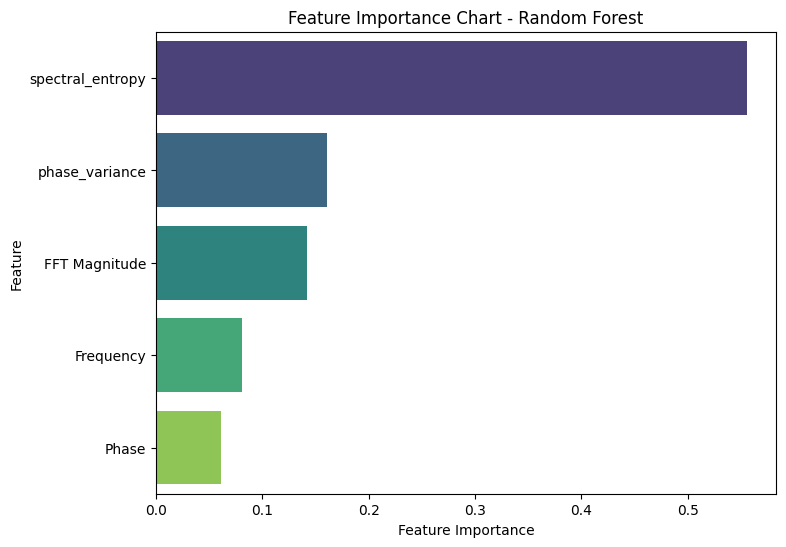

In [ ]:
# CM_LOG: True

# Feature Importance Plot
importances = clf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Chart - Random Forest")
plt.show()


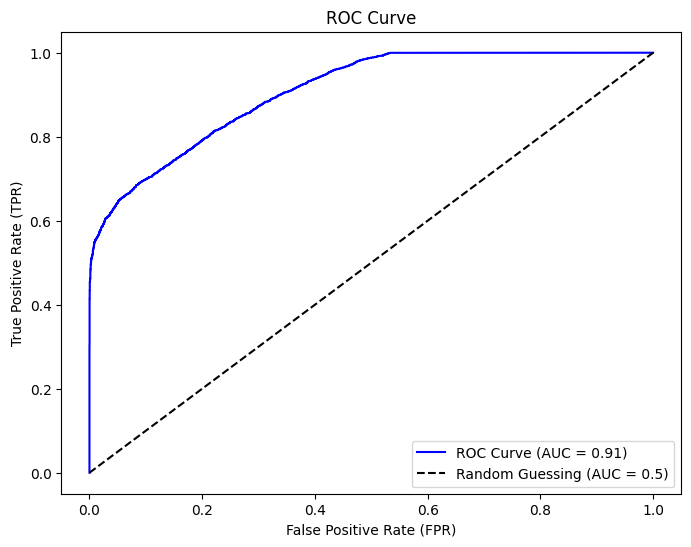

In [ ]:
# CM_LOG: True

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability of positive class

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC score
auc_score = roc_auc_score(y_test, y_prob)
auc_score
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing (AUC = 0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [62]:
import os
import joblib

# --- Define absolute base directory (2 levels up from current script) ---
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "/Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code"))

# --- Define directories for saving XGBoost model and scaler ---
misc_dir = os.path.join(BASE_DIR, "Misc")
model_dir = os.path.join(BASE_DIR, "Models", "Baby Detection and Seat Classification XGBoost")

# Ensure directories exist
os.makedirs(misc_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# --- Paths for saving model + scaler ---
model_path = os.path.join(misc_dir, "xgboost_model_Seat_classification.json")
scaler_path = os.path.join(model_dir, "xgboost_scaler_Seat_classification.pkl")

# --- Check and replace existing XGBoost model ---
if os.path.exists(model_path):
    os.remove(model_path)
    print(f"Old model removed: {model_path}")

clf.save_model(model_path)
print(f"New model saved at: {os.path.abspath(model_path)}")

# --- Check and replace existing scaler ---
if os.path.exists(scaler_path):
    os.remove(scaler_path)
    print(f"Old scaler removed: {scaler_path}")

joblib.dump(scaler, scaler_path)
print(f"New scaler saved at: {os.path.abspath(scaler_path)}")


Old model removed: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Misc/xgboost_model_Seat_classification.json
New model saved at: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Misc/xgboost_model_Seat_classification.json
Old scaler removed: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Baby Detection and Seat Classification XGBoost/xgboost_scaler_Seat_classification.pkl
New scaler saved at: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Baby Detection and Seat Classification XGBoost/xgboost_scaler_Seat_classification.pkl


In [63]:
import xgboost as xgb

# Load the trained XGBoost model
#clf = xgb.XGBClassifier()
#clf.load_model('xgboost_model_Seat_classification.json')

# Load the scaler
#scaler = joblib.load('scaler_Seat_classification.pkl')

# Example: Transform new data and make predictions
#X_new_scaled = scaler.transform(X_new)
#y_pred = clf.predict(X_new_scaled)


# MLP Model

In [64]:
# MLP model with raw data

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load dataset
X = dataset_1_rawdata.drop(columns=['Object_Presence']).values
y = dataset_1_rawdata['Object_Presence'].values

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build MLP model with an explicit Input() layer
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input layer
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
mlp_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
mlp_loss, mlp_acc = mlp_model.evaluate(X_test, y_test)
print(f"MLP Accuracy: {mlp_acc:.4f}")


Epoch 1/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - accuracy: 0.6539 - loss: 0.6267 - val_accuracy: 0.6581 - val_loss: 0.6218
Epoch 2/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6559 - loss: 0.6234 - val_accuracy: 0.6592 - val_loss: 0.6219
Epoch 3/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.6558 - loss: 0.6229 - val_accuracy: 0.6574 - val_loss: 0.6196
Epoch 4/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.6567 - loss: 0.6217 - val_accuracy: 0.6587 - val_loss: 0.6199
Epoch 5/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - accuracy: 0.6568 - loss: 0.6206 - val_accuracy: 0.6583 - val_loss: 0.6193
Epoch 6/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.6571 - loss: 0.6201 - val_accuracy: 0.6592 - val_loss: 0.6163
Epoch 7/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.6560 - loss: 0.6184 - val_accuracy: 0.6589 - val_loss: 0.6152
Epoch 8/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.6584 -

289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
MLP Accuracy: 0.6611

Classification Report for rawdata:
               precision    recall  f1-score   support

         0.0       0.64      0.87      0.74      5020
         1.0       0.73      0.41      0.52      4212

    accuracy                           0.66      9232
   macro avg       0.68      0.64      0.63      9232
weighted avg       0.68      0.66      0.64      9232



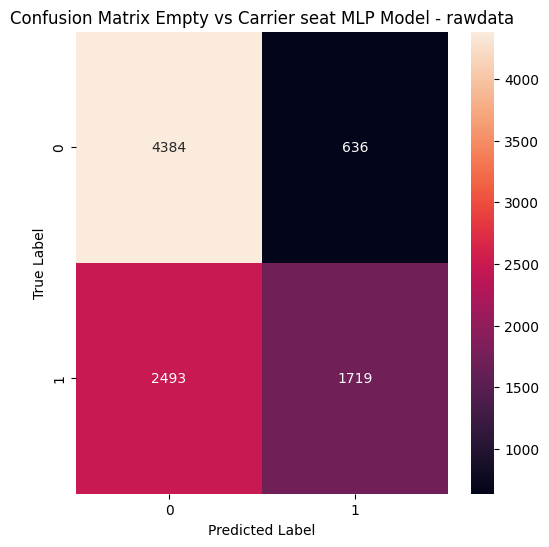

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import Image, display

# Get model predictions (convert probabilities to binary values: 0 or 1)
y_pred_prob = mlp_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary

# Print accuracy
print(f"MLP Accuracy: {mlp_acc:.4f}")

# Classification report
print("\nClassification Report for rawdata:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Empty vs Carrier seat MLP Model - rawdata")
plt.show()
# CM_LOG: True

# Save figure to buffer and display as image
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches="tight")
buf.seek(0)
display(Image(data=buf.getvalue()))  # <---- This makes nbformat save the PNG, not text
plt.close(fig)



In [67]:
# MLP model with extracted features

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load dataset
X = dataset_1_withfeatures.drop(columns=['Object_Presence']).values
y = dataset_1_withfeatures['Object_Presence'].values

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build MLP model with an explicit Input() layer
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input layer
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
mlp_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
mlp_loss, mlp_acc = mlp_model.evaluate(X_test, y_test)
print(f"MLP Accuracy: {mlp_acc:.4f}")


Epoch 1/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step - accuracy: 0.9981 - loss: 0.0144 - val_accuracy: 1.0000 - val_loss: 8.1678e-05
Epoch 2/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - accuracy: 1.0000 - loss: 2.1790e-05 - val_accuracy: 1.0000 - val_loss: 2.2777e-05
Epoch 3/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 1.0000 - loss: 6.7323e-06 - val_accuracy: 1.0000 - val_loss: 1.0825e-05
Epoch 4/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 1.0000 - loss: 2.7798e-06 - val_accuracy: 1.0000 - val_loss: 5.6099e-06
Epoch 5/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 1.0000 - loss: 1.2855e-06 - val_accuracy: 1.0000 - val_loss: 2.6378e-06
Epoch 6/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 1.0000 - loss: 6.2921e-07 - val_accuracy: 1.0000 - val_loss: 1.2746e-06
Epoch 7/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - accuracy: 1.0000 - loss: 3.1758e-07 - val_accuracy: 1.0000 - val_loss: 6.1586e-07
Epoch 8/10
1154/1154 ━━━

289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
MLP Accuracy: 1.0000

Classification Report for extracted features data:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5020
         1.0       1.00      1.00      1.00      4212

    accuracy                           1.00      9232
   macro avg       1.00      1.00      1.00      9232
weighted avg       1.00      1.00      1.00      9232



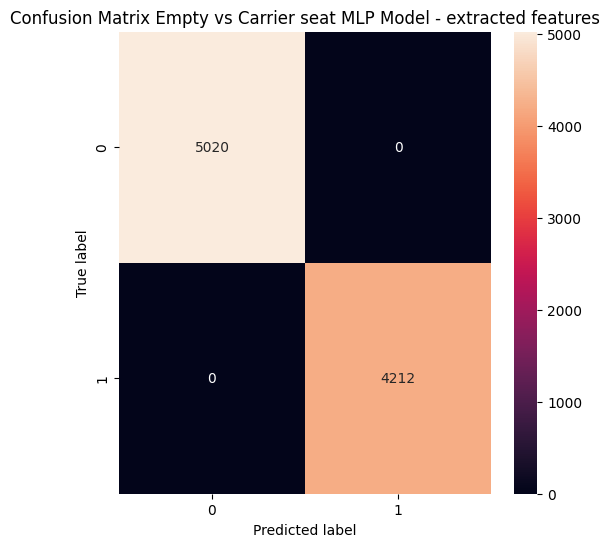

In [ ]:


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import Image, display

# Get model predictions (convert probabilities to binary values: 0 or 1)
y_pred_prob = mlp_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary

# Print accuracy
print(f"MLP Accuracy: {mlp_acc:.4f}")

# Classification report
print("\nClassification Report for extracted features data:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix Empty vs Carrier seat MLP Model - extracted features")
plt.show()
# CM_LOG: True
# Save figure to buffer and display as image
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches="tight")
buf.seek(0)
display(Image(data=buf.getvalue()))  # <---- This makes nbformat save the PNG, not text
plt.close(fig)


In [70]:
# MLP model with selected features using correlation matrix for overcoming overfitting

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load dataset
X = dataset_1_reduced.drop(columns=['Object_Presence']).values
y = dataset_1_reduced['Object_Presence'].values

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build MLP model with an explicit Input() layer
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input layer
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
mlp_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
mlp_loss, mlp_acc = mlp_model.evaluate(X_test, y_test)
print(f"MLP Accuracy: {mlp_acc:.4f}")


Epoch 1/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - accuracy: 0.7676 - loss: 0.4578 - val_accuracy: 0.7838 - val_loss: 0.4155
Epoch 2/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7900 - loss: 0.4013 - val_accuracy: 0.7942 - val_loss: 0.3918
Epoch 3/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7984 - loss: 0.3828 - val_accuracy: 0.8005 - val_loss: 0.3735
Epoch 4/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.8019 - loss: 0.3724 - val_accuracy: 0.8061 - val_loss: 0.3677
Epoch 5/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.8037 - loss: 0.3650 - val_accuracy: 0.8063 - val_loss: 0.3588
Epoch 6/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.8066 - loss: 0.3586 - val_accuracy: 0.8068 - val_loss: 0.3544
Epoch 7/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.8077 - loss: 0.3561 - val_accuracy: 0.8071 - val_loss: 0.3540
Epoch 8/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.8087 -

289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
MLP Accuracy: 0.8067

Classification Report for selected features data:
               precision    recall  f1-score   support

         0.0       0.77      0.92      0.84      5020
         1.0       0.87      0.68      0.76      4212

    accuracy                           0.81      9232
   macro avg       0.82      0.80      0.80      9232
weighted avg       0.82      0.81      0.80      9232



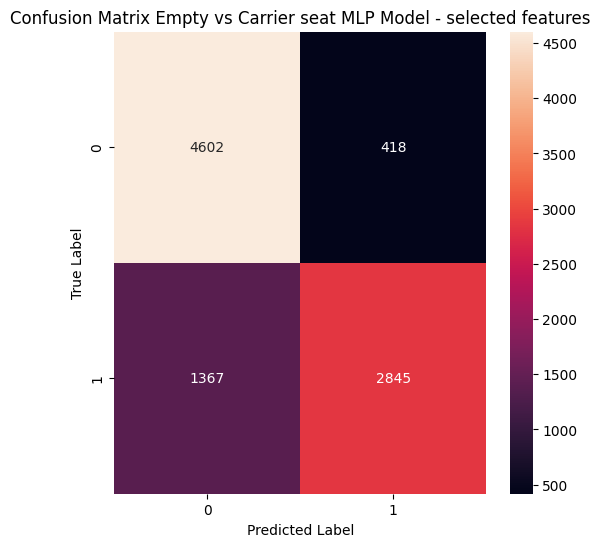

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import Image, display

# Get model predictions (convert probabilities to binary values: 0 or 1)
y_pred_prob = mlp_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary

# Print accuracy
print(f"MLP Accuracy: {mlp_acc:.4f}")

# Classification report
print("\nClassification Report for selected features data:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Empty vs Carrier seat MLP Model - selected features")
plt.show()
# CM_LOG: True

# Save figure to buffer and display as image
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches="tight")
buf.seek(0)
display(Image(data=buf.getvalue()))  # <---- This makes nbformat save the PNG, not text
plt.close(fig)

In [73]:
import os
import joblib
from tensorflow.keras.models import load_model

# --- Define absolute base directory (2 levels up from current script) ---
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "/Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code"))

# --- Define save directory for MLP model ---
save_dir = os.path.join(BASE_DIR, "Models", "Seat Classification")

# Make sure the directory exists
os.makedirs(save_dir, exist_ok=True)

# --- Paths for saving model and scaler ---
model_path = os.path.join(save_dir, "mlp_model_Seat_Classification.h5")
scaler_path = os.path.join(save_dir, "mlp_scaler_Seat_Classification.pkl")

# --- Check and replace existing model ---
if os.path.exists(model_path):
    os.remove(model_path)
    print(f"Old model removed: {model_path}")

mlp_model.save(model_path)
print(f"New model saved at: {os.path.abspath(model_path)}")

# --- Check and replace existing scaler ---
if os.path.exists(scaler_path):
    os.remove(scaler_path)
    print(f"Old scaler removed: {scaler_path}")

joblib.dump(scaler, scaler_path)
print(f"New scaler saved at: {os.path.abspath(scaler_path)}")


Old model removed: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Seat Classification/mlp_model_Seat_Classification.h5
New model saved at: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Seat Classification/mlp_model_Seat_Classification.h5
Old scaler removed: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Seat Classification/mlp_scaler_Seat_Classification.pkl
New scaler saved at: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Seat Classification/mlp_scaler_Seat_Classification.pkl


In [74]:
# Load the trained model
#mlp_model = load_model('mlp_model_Seat_Classification.h5')

# Load the scaler
#scaler = joblib.load('scaler_Seat_Classification.pkl')

# Example: Transform new data and make predictions
#X_new_scaled = scaler.transform(X_new)
#y_pred = mlp_model.predict(X_new_scaled)
